In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras

from src.FramePredictionTF import create_next_frame_prediction_model

In [ ]:
[f for f in os.scandir("data")][0].is_dir

<DirEntry '0'>

In [9]:
X = []
Y = []

folders = [f.name for f in os.scandir("data") if f.is_dir()]
folders = [int(n) for n in folders]
folders.sort()

for folder in folders:

    print(f"Loading {folder}", end="\r")
    
    rho = np.load(f"data/{folder}/smoke.npy")
    rho = np.expand_dims(rho, -1)
    velocity = np.load(f"data/{folder}/velocity.npy")
    p = np.load(f"data/{folder}/pressure.npy")
    p = np.expand_dims(p, -1)
    
    x = np.concatenate([rho, velocity, p], axis=-1)  # Density, Velocity X, Velocity Y, Pressure
    
    y = x[5:]
    x = x[:-5]
    
    X.append(x)
    Y.append(y)

X = np.concatenate(X, axis=0)
Y = np.concatenate(Y, axis=0)

X.shape, Y.shape

((14500, 64, 64, 4), (14500, 64, 64, 4))

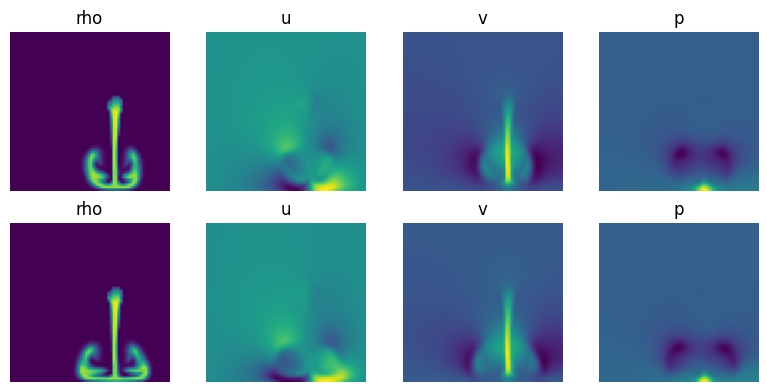

In [10]:
idx = 59

fig, axs = plt.subplots(2, 4, figsize=(8,4))

# Current frame
axs[0,0].imshow(X[idx,:,:,0])
axs[0,0].set_title("rho")
axs[0,0].axis("off")

axs[0,1].imshow(X[idx,:,:,1])
axs[0,1].set_title("u")
axs[0,1].axis("off")

axs[0,2].imshow(X[idx,:,:,2])
axs[0,2].set_title("v")
axs[0,2].axis("off")

axs[0,3].imshow(X[idx,:,:,3])
axs[0,3].set_title("p")
axs[0,3].axis("off")

# Next frame
idx_next = idx + 5
axs[1,0].imshow(Y[idx,:,:,0])
axs[1,0].set_title("rho")
axs[1,0].axis("off")

axs[1,1].imshow(Y[idx,:,:,1])
axs[1,1].set_title("u")
axs[1,1].axis("off")

axs[1,2].imshow(Y[idx,:,:,2])
axs[1,2].set_title("v")
axs[1,2].axis("off")

axs[1,3].imshow(Y[idx,:,:,3])
axs[1,3].set_title("p")
axs[1,3].axis("off")

plt.tight_layout()

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

In [ ]:
from src.FramePredictionTF import create_unet_model

In [ ]:
input_frame_shape = (64, 64, 4)

# CNN model
# cnn_filters = [32, 64, 32] 
# model = create_next_frame_prediction_model(
#     input_shape=input_frame_shape,
#     filters_list=cnn_filters
# )

# U-Net model
model = create_unet_model(input_frame_shape)

model.summary()

In [21]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=2e-3),
              loss='mse',
              metrics=['accuracy'])

callbacks = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=5e-6),  # type: ignore
             keras.callbacks.EarlyStopping(monitor='val_loss', patience=9, restore_best_weights=True)]

In [22]:
EPOCHS = 50
BATCH_SIZE = 32

In [ ]:
# loss: 0.2024 - accuracy: 0.5734

In [ ]:
history = model.fit(x=X_train, y=Y_train, validation_data=(X_test, Y_test), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, verbose=1)  # type: ignore

Epoch 1/50
408/408 [==============================] - 261s 638ms/step - loss: 0.1186 - accuracy: 0.7623 - val_loss: 0.1128 - val_accuracy: 0.8009 - lr: 0.0020
Epoch 2/50
408/408 [==============================] - 274s 673ms/step - loss: 0.1038 - accuracy: 0.8363 - val_loss: 0.1066 - val_accuracy: 0.8538 - lr: 0.0020
Epoch 3/50
408/408 [==============================] - 290s 710ms/step - loss: 0.1029 - accuracy: 0.8445 - val_loss: 0.1061 - val_accuracy: 0.8511 - lr: 0.0020
Epoch 4/50
408/408 [==============================] - 268s 656ms/step - loss: 0.1025 - accuracy: 0.8482 - val_loss: 0.1058 - val_accuracy: 0.8553 - lr: 0.0020
Epoch 5/50
408/408 [==============================] - 268s 657ms/step - loss: 0.1023 - accuracy: 0.8519 - val_loss: 0.1054 - val_accuracy: 0.8664 - lr: 0.0020
Epoch 6/50
408/408 [==============================] - 265s 648ms/step - loss: 0.1021 - accuracy: 0.8551 - val_loss: 0.1054 - val_accuracy: 0.8638 - lr: 0.0020
Epoch 7/50
408/408 [==========================

In [ ]:
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], color="tab:blue")
        ax[idx].set_xlabel('Epochs')
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_'+metric], ls='dashed')
        ax[idx].legend(['train_'+metric, 'val_'+metric])

    plt.tight_layout()

In [ ]:
training_plot(['loss', 'accuracy'], history)

## Predict

In [111]:
Y_pred = model.predict(X_test)
error = np.abs(Y_test - Y_pred) ** 2

46/46 [==============================] - 25s 534ms/step


In [113]:
error.max()

105.92308

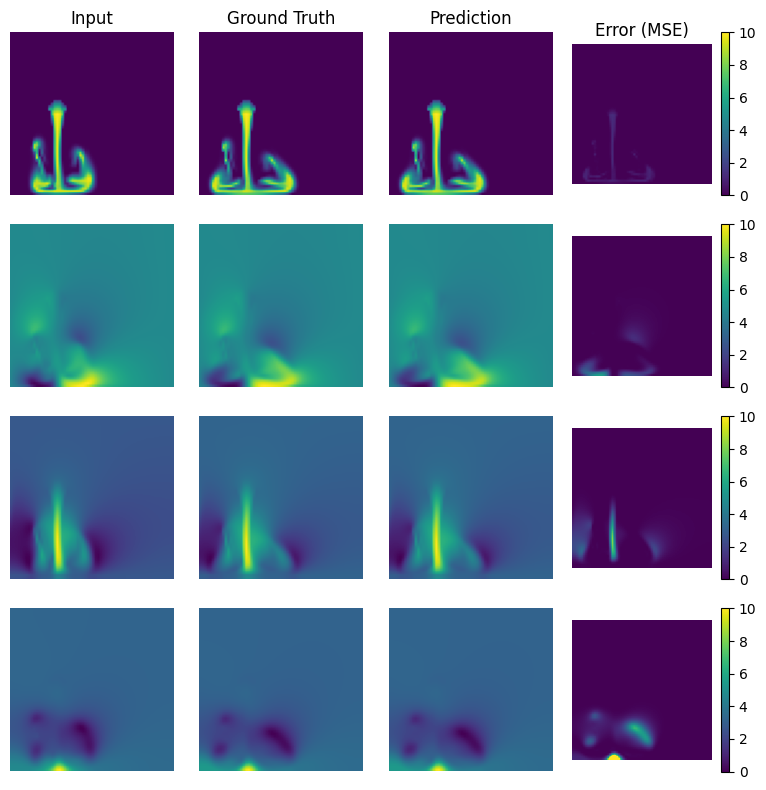

In [115]:
idx = 5

fig, axs = plt.subplots(4, 4, figsize=(8,8))

# Input
axs[0,0].imshow(X_test[idx,:,:,0])
axs[0,0].set_title("Input")
axs[0,0].set_ylabel("rho")
axs[0,0].axis("off")

axs[1,0].imshow(X_test[idx,:,:,1])
axs[1,0].set_ylabel("u")
axs[1,0].axis("off")

axs[2,0].imshow(X_test[idx,:,:,2])
axs[2,0].set_ylabel("v")
axs[2,0].axis("off")

axs[3,0].imshow(X_test[idx,:,:,3])
axs[3,0].set_ylabel("p")
axs[3,0].axis("off")

# Ground Truth
axs[0,1].imshow(Y_test[idx,:,:,0])
axs[0,1].set_title("Ground Truth")
axs[0,1].set_ylabel("rho")
axs[0,1].axis("off")

axs[1,1].imshow(Y_test[idx,:,:,1])
axs[1,1].set_ylabel("u")
axs[1,1].axis("off")

axs[2,1].imshow(Y_test[idx,:,:,2])
axs[2,1].set_ylabel("v")
axs[2,1].axis("off")

axs[3,1].imshow(Y_test[idx,:,:,3])
axs[3,1].set_ylabel("p")
axs[3,1].axis("off")

# Prediction
axs[0,2].imshow(Y_pred[idx,:,:,0])
axs[0,2].set_title("Prediction")
axs[0,2].set_ylabel("rho")
axs[0,2].axis("off")

axs[1,2].imshow(Y_pred[idx,:,:,1])
axs[1,2].set_ylabel("u")
axs[1,2].axis("off")

axs[2,2].imshow(Y_pred[idx,:,:,2])
axs[2,2].set_ylabel("v")
axs[2,2].axis("off")

axs[3,2].imshow(Y_pred[idx,:,:,3])
axs[3,2].set_ylabel("p")
axs[3,2].axis("off")

# Error
im = axs[0,3].imshow(error[idx,:,:,0], vmin=0, vmax=10)
axs[0,3].set_title("Error (MSE)")
axs[0,3].set_ylabel("rho")
axs[0,3].axis("off")
plt.colorbar(im)

im = axs[1,3].imshow(error[idx,:,:,1], vmin=0, vmax=10)
axs[1,3].set_ylabel("u")
axs[1,3].axis("off")
plt.colorbar(im)

im = axs[2,3].imshow(error[idx,:,:,2], vmin=0, vmax=10)
axs[2,3].set_ylabel("v")
axs[2,3].axis("off")
plt.colorbar(im)

im = axs[3,3].imshow(error[idx,:,:,3], vmin=0, vmax=10)
axs[3,3].set_ylabel("p")
axs[3,3].axis("off")
plt.colorbar(im)

plt.tight_layout()

In [ ]:
x = X[[0]]

frames = [x[0]]

for i in range(30):
    print(i, end="\r")
    x = model.predict(x, verbose=0)
    frames.append(x[0])

frames = np.array(frames)

In [141]:
import numpy as np
from PIL import Image

def save_gif(smoke_array, velocity_array, pressure_array):
    # Scale to 0 - 255
    # NewValue = (((OldValue - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin
    smoke_array_scaled = (((smoke_array - smoke_array.min()) * 255) / (smoke_array.max() - smoke_array.min())).astype(np.uint8)
    velocity_array_scaled = (((velocity_array - velocity_array.min()) * 255) / (velocity_array.max() - velocity_array.min())).astype(np.uint8)
    pressure_array_scaled = (((pressure_array - pressure_array.min()) * 255) / (pressure_array.max() - pressure_array.min())).astype(np.uint8)

    data_dict = {"rho": smoke_array_scaled,
                "u": velocity_array_scaled[:,:,:,0],
                "v": velocity_array_scaled[:,:,:,1],
                "p": pressure_array_scaled}

    for name, img_array in data_dict.items():

        imgs = [Image.fromarray(img) for img in img_array]
        # duration is the number of milliseconds between frames; this is 40 frames per second
        imgs[0].save(f"data/{name}.gif", save_all=True, append_images=imgs[1:], duration=50, loop=0)

In [142]:
smoke_array = frames[:,:,:,0]
velocity_array = frames[:,:,:,1:3]
pressure_array = frames[:,:,:,3]

save_gif(smoke_array, velocity_array, pressure_array)